In [19]:
!pip install textstat

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     -------------------------------------- 105.1/105.1 kB 1.5 MB/s eta 0:00:00
     ---------------------------------------- 2.0/2.0 MB 7.4 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
import math
from tqdm import tqdm
from datetime import datetime
import pandas as pd
import numpy as np
import os
import gensim
import torch
import sentence_transformers
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn

from transformers import BertTokenizer, BertModel, pipeline, BartModel
from transformers import RobertaTokenizer, RobertaModel, AutoConfig

from sentence_transformers.util import cos_sim
from sentence_transformers import SentenceTransformer, models
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics.pairwise import cosine_similarity
import torch.nn.functional as F

from collections import OrderedDict

import textstat

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [3]:
def config_model():
    configuration = AutoConfig.from_pretrained('roberta-base')

    configuration.hidden_dropout_prob = 0.0
    configuration.attention_probs_dropout_prob = 0.0
    configuration.classifier_dropout = 0.0
    
    return configuration

In [5]:
# ROBERTa model

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
embeddings_model = RobertaModel.from_pretrained('roberta-base', config=config_model())
summarizer = pipeline("summarization", model="bart-large-cnn")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
sentence_tokenizer = AutoTokenizer.from_pretrained('all-mpnet-base-v2')
sentence_model = AutoModel.from_pretrained('all-mpnet-base-v2')

In [6]:
summaries_test_path = r"dataset\summaries_train.csv"
prompts_test_path = r"dataset\prompts_train.csv"

In [22]:
with open(prompts_test_path, encoding='utf-8') as f:
    prompts = pd.read_csv(f)
    
with open(summaries_test_path, encoding='utf-8') as f:
    summaries = pd.read_csv(f)

In [23]:
summaries = summaries.merge(prompts, how="left", on="prompt_id")

## Stuff

# Getting text features/ wording

In [24]:
summaries.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \nThe Third Wave experiment took pl...
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \nThe Third Wave experiment took pl...


In [25]:
def get_stat_features(df, text_col="text"):
    df["num_unique_words"] = df[text_col].apply(lambda x: len(set(x.split())))
    df["num_words"] = df[text_col].apply(lambda x: len(x.split()))
    df["num_sentences"] = df[text_col].apply(lambda x: len(x.split('.')))
#     df["isupper"] = df[text_col].apply(lambda x: x[0].isupper())
#     df["mean_num_words"] = df[text_col].apply(lambda x: np.mean([len(e.split()) for e in x.split('.')]))
#     df["mean_num_unique_words"] = df[text_col].apply(lambda x: np.mean([len(set(e.split())) for e in x.split('.')]))
#     df["num_slash"] = df[text_col].apply(lambda x: x.count("\n"))
#     df["paragraph_count"] = df[text_col].apply(lambda x: x.count("\n\n"))
#     df["upper_count"] = df[text_col].apply(lambda x: np.sum([w.isupper() for w in x.split()])/len(x.split()))
    df["syntax_count"] = df[text_col].apply(lambda x: x.count(",") + x.count("-") + x.count(";") + x.count(":"))
    
#     df["num_unique_words_prompt_text"] = df["prompt_text"].apply(lambda x: len(set(x.split()))) - df["num_unique_words"]
#     df["num_words_prompt_text"] = df["prompt_text"].apply(lambda x: len(x.split())) - df["num_words"]
#     df["num_sentences_prompt_text"] = df["prompt_text"].apply(lambda x: len(x.split('.'))) - df["num_sentences"]
    
#     df["stopwords_rel"] = df[text_col].apply(lambda x: get_stopwords_rel(x))
#     df['diff_emb_sb'] = df.apply(lambda x: np.sum(get_emb_sb(x["text"])*get_emb_sb(x["prompt_text"])), axis=1)
#     df['diff_emb_qa'] = df.apply(lambda x: np.sum(get_emb_qa(x["text"])*get_emb_qa(x["prompt_question"])), axis=1)
#     df['ch'] = df.apply(lambda x: get_ch_label(x["text"]), axis=1)
#     df['rw'] = df.apply(lambda x: get_rw(x["prompt_question"], x["text"]), axis=1)

#     df['automated_readability_index'] = df[text_col].apply(lambda x: textstat.automated_readability_index(x))
#     df['coleman_liau_index'] = df[text_col].apply(lambda x: textstat.coleman_liau_index(x))
    df['smog_index'] = df[text_col].apply(lambda x: textstat.smog_index(x))
#     df['dale_chall_readability_score'] = df[text_col].apply(lambda x: textstat.dale_chall_readability_score(x))
#     df['linsear_write_formula'] = df[text_col].apply(lambda x: textstat.linsear_write_formula(x))
#     df['gunning_fog'] = df[text_col].apply(lambda x: textstat.gunning_fog(x))
#     df['text_standard_float'] = df[text_col].apply(lambda x: textstat.text_standard(x, float_output=True))
#     df['spache_readability'] = df[text_col].apply(lambda x: textstat.spache_readability(x))
#     df['rix'] = df[text_col].apply(lambda x: textstat.rix(x))
#     df['lix'] = df[text_col].apply(lambda x: textstat.lix(x))

    return df

In [28]:
summaries_with_features = get_stat_features(summaries)

In [29]:
summaries_with_features.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,num_unique_words,num_words,num_sentences,syntax_count,smog_index
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \nThe Third Wave experiment took pl...,51,61,4,0,10.7
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",38,52,3,0,0.0
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,149,235,13,19,9.3
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,19,25,5,0,9.7
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \nThe Third Wave experiment took pl...,138,203,14,5,10.1


In [31]:
for i, text in enumerate(tqdm(prompts.prompt_text)):
    if len(text.split()) > 384:
        short_version = short_text(text, max_length=384)
        prompts.prompt_text[i] = short_version

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:18<00:00, 34.73s/it]


In [32]:
prompt_text = prompts.prompt_text[2]

In [39]:
summaries = summaries.sort_values('content').reset_index(drop=True)

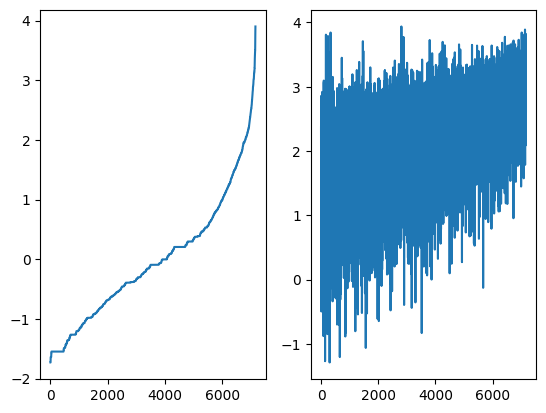

In [117]:
plt.subplot(1,2,1)
plt.plot(summaries.content)

plt.subplot(1,2,2)
plt.plot(summaries.cos_score)

In [49]:
sentence_1 = prompts.prompt_text[0]
prompt_num = prompts.prompt_id[0]

In [56]:
sentence_2 = summaries[summaries.prompt_id == prompt_num].reset_index(drop=True).text[1000]

In [89]:
inputs = sentence_tokenizer([sentence_1, sentence_2], padding=True,
          return_tensors='pt', truncation=True)

In [99]:
inputs;

In [91]:
with torch.no_grad():
    outputs = sentence_model(**inputs)

In [92]:
sentence_embeddings = mean_pooling(outputs, inputs)

In [94]:
sentence_embeddings = F.normalize(sentence_embeddings)

In [97]:
sentence_embeddings.shape

torch.Size([2, 768])

In [98]:
nn.CosineSimilarity(dim=0)(sentence_embeddings[0], sentence_embeddings[1])

tensor(0.6790)

In [108]:
cos_sim = nn.CosineSimilarity(dim=0)
cos_score_list = []
sentence_model.to(device)

for i, sentence_1 in enumerate(tqdm(summaries.text)):
    sentence_2 = prompts.prompt_text[prompts.prompt_id == summaries.prompt_id[i]].item()
    
    inputs = sentence_tokenizer([sentence_1, sentence_2], padding=True,
          return_tensors='pt', truncation=True)
    inputs = inputs.to(device)
    
    with torch.no_grad():
        outputs = sentence_model(**inputs)
    
    sentence_embeddings = mean_pooling(outputs, inputs)
    
    sentence_embeddings = F.normalize(sentence_embeddings)
    
    cos_score = cos_sim(sentence_embeddings[0], sentence_embeddings[1])
    
    cos_score_list.append(cos_score.item())
    
summaries['cos_score'] = cos_score_list

100%|██████████████████████████████████████████████████████████████████████████████| 7165/7165 [01:56<00:00, 61.41it/s]


In [111]:
summaries['cos_score'] = cos_score_list

In [116]:
summaries.cos_score = (summaries.cos_score * 6.1) - 1.8

## e.o. Stuff

In [12]:
def norm_score(df: pd.DataFrame) -> pd.DataFrame:
    """Normilizing score to values 0 to 1"""
    df -= np.min(df)
    df /= df.max()
    print('Normilized' if df.min() == 0.0 and df.max() == 1.0 else 'NormError:wrong values')
    
    return df

def short_text(text, max_length=512) -> str:
    if len(text.split()) > 700:
        middle_point = text[len(text)//2:].index('.') + len(text)//2 + 1
        text_pt1 = text[:middle_point]
        text_pt2 = text[middle_point:]
        
        text = short_text(text_pt1) + short_text(text_pt2)
        
    summarized = summarizer(text, max_length=max_length, min_length=100, do_sample=False)
    
    return summarized[0]['summary_text']

def moving_average(array: np.array, betta=0.9) -> np.array:
    """
    Computing moving average with bias correction.
    """
    
    V = 0
    average_array = np.zeros(len(array))
    for i in range(len(array)):
        V = betta * V + (1 - betta) * array[i]
        average_array[i] = V/(1 - pow(betta, i+1))
        
    return average_array



def mean_pooling(outputs, batch) -> torch.tensor:
    
    attention_mask = batch['attention_mask']
    embeddings = outputs.last_hidden_state
    
    mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
    masked_embeddings = embeddings * mask
    
    summed = torch.sum(masked_embeddings, 1)
    summed_mask = torch.clamp(mask.sum(dim=1), min=1e-9)
    
    mean_pooled = summed/summed_mask
    
    return mean_pooled

In [ ]:
#content

#39c16e -1.729 3.900
#3b9047  -1.729 3.894
#814d6b -1.729 3.711
#ebad26 -1.638 3.503

In [11]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim ** 0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted
    

In [15]:
class STSBertModel(nn.Module):
    """
    Sentence Semantic Similarity Bert model
    :param: seg_head=True for using segmentation head instead of cosine similarity
    :param: freeze_weights=True to freeze BERT model's weights and train only the segmentation head
    """
    def __init__(self, seg_head=False, freeze_weights=False, input_size=768):
        super(STSBertModel, self).__init__()
        
        self.word_embedding = RobertaModel.from_pretrained('roberta-base')
        self.cos_score = nn.CosineSimilarity(dim=0)
        self.identity = nn.Identity()
        self.seg_head = seg_head
        self.input_size = input_size
        
        self.attention = SelfAttention(self.input_size)
    
        self.FC_head = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(self.input_size, 1))
            ]))
            
        if freeze_weights:
            self.freeze()
    
    def freeze(self):
        for param in self.word_embedding.parameters():
            param.requires_grad = False
    
    def cos_score(self, x):
        embedding_1 = x[0]
        embedding_2 = x[1]
        
        cos_score = self.cos_sim(embedding_1, embedding_2)
#         cos_score = torch.sigmoid(cos_score)
        
        return cos_score
    
    def forward(self, x):
        output = self.word_embedding(**x)
        
        if self.seg_head:
            output = mean_pooling(output, x)
            output = self.attention(output.unsqueeze(1))

#             output = self.attention(output[0])
#             output = torch.mean(output, dim=1)
#             output = torch.max(output, dim=1).values
            
            output = self.FC_head(output)
        
        else:
            cos_sim = self.cos_score(output)
            
            output = torch.mean(output, dim=1)
            
            features = torch.concat((output, cos_sim))
            self.input_size += 1
            
            output = self.attention(features.unsqueeze(1))
            
            output = self.FC_head(output)
        
        return output

In [16]:
content_model = STSBertModel(seg_head=True, freeze_weights=False)
    
content_model.load_state_dict(torch.load(r'models\cv\best__fold_1.pt'))

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [19]:
torch.load(r'models\cv\best__fold_1.pt')['word_embedding.embeddings.position_ids']

KeyError: 'word_embedding.embeddings.position_ids'

In [17]:
content_model.word_embedding.embeddings.position_ids

tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
         112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
         126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
         140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
         154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
         168, 169, 170, 171, 172, 173, 174, 175, 176

In [7]:
def predict_content_score():
    
    content = []
    
    content_model = STSBertModel(seg_head=True, freeze_weights=False)
    
    content_model.load_state_dict(torch.load(r'models\cv\best__fold_1.pt'))
    
    content_model.to(device)
    content_model.eval()
    
    
    for i, student_id in enumerate(tqdm(summaries.student_id)):
        summary = summaries.text[i]
        
        tokens = tokenizer(summary, padding='max_length', return_tensors='pt', truncation=True)
        tokens = tokens.to(device)
        
        content_score = content_model(tokens)

        content.append(content_score.item())
    
    return content
    
def predict_wording_score():
    
    wording = []
    
    wording_model = STSBertModel(seg_head=True, freeze_weights=False)
    
    wording_model.load_state_dict(torch.load(r'models\RoBerta_wording_8l.pt'))
    
    wording_model.to(device)
    wording_model.eval()
    
    for i, student_id in enumerate(tqdm(summaries.student_id)):
        summary = summaries.text[i]
        
        tokens = tokenizer(summary, padding='max_length', return_tensors='pt', truncation=True)
        tokens = tokens.to(device)
        
        wording_score = wording_model(tokens)

        wording.append(wording_score.item())
        
    return wording

In [15]:

    
submission = {'student_id': summaries.student_id, 'content': predict_content_score(),
              'wording': predict_wording_score()}

submission_df = pd.DataFrame.from_dict(submission)
# submission_df.to_csv('submission.csv',index=False)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 7165/7165 [01:26<00:00, 82.58it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 7165/7165 [01:26<00:00, 83.13it/s]


In [16]:
torch.cuda.empty_cache()

In [15]:
del content_model, wording_model

In [18]:
submission_df

,student_id,content,wording
0,000e8c3c7ddb,0.398765,0.771343
1,0020ae56ffbf,-0.500760,0.244957
2,004e978e639e,2.586437,0.911615
3,005ab0199905,-0.845013,0.006656
4,0070c9e7af47,2.190113,1.071828
...,...,...,...
7160,ff7c7e70df07,0.017408,0.258897
7161,ffc34d056498,0.025435,0.303351
7162,ffd1576d2e1b,-1.056069,0.077803
7163,ffe4a98093b2,0.056168,0.689005
